In [1]:
import json

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import catboost as cb
import shap

from sklearn.metrics import r2_score

In [2]:
features_dir = Path("data") / "features"

X_train = pd.read_csv(features_dir / "X_train.csv")
X_test = pd.read_csv(features_dir / "X_test.csv")
y_train = pd.read_csv(features_dir / "y_train.csv")
y_test = pd.read_csv(features_dir / "y_test.csv")

with open(features_dir / "meta.json", "r") as f:
    meta = json.load(f)

categorical_features = meta["categorical_features"]

In [3]:
X_train.head()

,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,...,host_verifications_email,host_verifications_government_id,host_verifications_jumio,host_verifications_phone,host_verifications_reviews,instant_bookable,is_bathroom_private,neighbourhood_cleansed,property_type,room_type
0,420673373,0.958782,1.00,1.00,0,0,52.29860,4.95581,2,1.0,...,0,0,0,0,0,0,0,0,0,0
1,429206111,0.970761,0.91,1.00,0,0,52.36525,4.87946,4,1.0,...,0,0,0,0,0,0,0,1,1,0
2,293464674,0.812589,1.00,1.00,1,1,51.92125,4.49959,2,1.0,...,0,1,1,0,0,0,0,2,2,1
3,80550302,0.575431,0.75,0.90,1,1,51.91032,4.52203,1,1.0,...,0,1,0,0,1,0,0,3,3,1
4,237371423,0.765076,0.92,0.99,8,8,52.38586,4.87644,2,1.0,...,0,1,0,0,0,0,0,4,4,1


In [4]:
X_test.head()

,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,...,host_verifications_email,host_verifications_government_id,host_verifications_jumio,host_verifications_phone,host_verifications_reviews,instant_bookable,is_bathroom_private,neighbourhood_cleansed,property_type,room_type
0,25677161,0.465990,1.0,0.88,1,1,52.375460,4.876560,4,2.0,...,0,1,1,0,1,1,1,4.0,3.0,1
1,5923086,0.337665,1.0,0.71,2,2,51.924070,4.491460,1,1.0,...,0,1,1,0,1,1,0,29.0,18.0,1
2,5878526,0.337056,1.0,0.57,1,1,52.360640,4.976430,4,1.0,...,0,1,1,0,1,1,0,41.0,10.0,0
3,837675,0.208731,1.0,1.00,1,1,52.382830,4.967150,4,2.0,...,0,1,1,0,1,1,0,6.0,27.0,0
4,32424525,0.489543,0.8,1.00,1,1,52.385609,4.878721,4,3.0,...,0,1,1,0,1,1,0,4.0,0.0,0


In [5]:
categorical_features

['host_response_time',
 'host_is_superhost',
 'host_neighbourhood',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'has_availability',
 'instant_bookable',
 'city',
 'has_license',
 'is_bathroom_private',
 'host_verifications_phone',
 'host_verifications_email',
 'host_verifications_jumio',
 'host_verifications_reviews',
 'host_verifications_government_id',
 'amenities_Wifi',
 'amenities_Essentials',
 'amenities_Smoke alarm',
 'amenities_Heating',
 'amenities_Hangers',
 'amenities_Long term stays allowed',
 'amenities_Kitchen',
 'amenities_Hair dryer',
 'amenities_Hot water',
 'amenities_Iron',
 'host_id']

In [6]:
y_train

,price
0,159.0
1,357.0
2,85.0
3,46.0
4,103.0
...,...
5723,94.0
5724,60.0
5725,180.0
5726,145.0


In [7]:
y_test.head()

,price
0,225.0
1,75.0
2,135.0
3,149.0
4,170.0


# Train

In [8]:
train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)

model = cb.CatBoostRegressor(loss_function="RMSE")

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 195.8707324	test: 182.1541706	best: 182.1541706 (0)	total: 48.6ms	remaining: 4.81s
1:	learn: 191.7488818	test: 177.8879132	best: 177.8879132 (1)	total: 49.8ms	remaining: 2.44s
2:	learn: 187.8538382	test: 173.8267937	best: 173.8267937 (2)	total: 50.6ms	remaining: 1.64s
3:	learn: 183.9533535	test: 169.8290778	best: 169.8290778 (3)	total: 51.7ms	remaining: 1.24s
4:	learn: 180.5263365	test: 166.2578765	best: 166.2578765 (4)	total: 53.1ms	remaining: 1.01s
5:	learn: 177.0165976	test: 162.5468364	best: 162.5468364 (5)	total: 54ms	remaining: 847ms
6:	learn: 173.5588951	test: 158.9657602	best: 158.9657602 (6)	total: 54.9ms	remaining: 730ms
7:	learn: 170.3349191	test: 155.7113539	best: 155.7113539 (7)	total: 56ms	remaining: 644ms
8:	learn: 167.1284782	test: 152.3224962	best: 152.3224962 (8)	total: 56.8ms	remaining: 574ms
9:	learn: 163.9946416	test: 148.9997365	best: 148.9997365 (9)	total: 57.8ms	remaining: 520ms
10:	learn: 161.1522126	test: 146.0590753	best: 146.0590753 (10)	total: 59m

{'params': {'depth': 8,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [9]:
y_test_pred = model.predict(X_test)

r2_score(y_test, y_test_pred)

0.6007897972095457

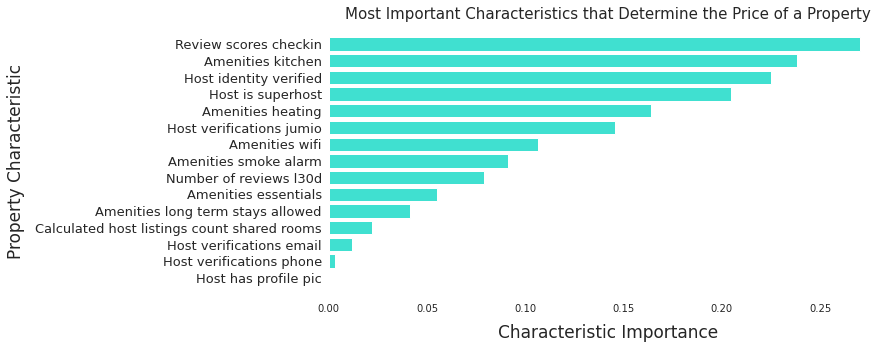

In [10]:
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", sns.color_palette("crest", as_cmap=True).colors)

sorted_feature_importance = model.feature_importances_.argsort()[:15]
display_features = X_train.columns[sorted_feature_importance]
display_features = [" ".join(f.capitalize().split("_")) for f in display_features]
_, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.barh(
    display_features,
    model.feature_importances_[sorted_feature_importance],
    color='turquoise'
)
ax.set_facecolor("white")
ax.set_xlabel("Characteristic Importance", fontsize=17)
ax.set_ylabel("Property Characteristic", fontsize=17)
ax.tick_params(axis='y', which='major', labelsize=13)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10

for txt in ax.texts:
    txt.set_visible(False)

ax.xaxis.set_major_formatter(FormatStrFormatter('%1.2f'))

plt.title("Most Important Characteristics that Determine the Price of a Property", fontsize=15)
plt.savefig(Path("images") / "catboost.png", bbox_inches = "tight")

In [11]:
X_test.columns[sorted_feature_importance]

Index(['host_has_profile_pic', 'host_verifications_phone',
       'host_verifications_email',
       'calculated_host_listings_count_shared_rooms',
       'amenities_Long term stays allowed', 'amenities_Essentials',
       'number_of_reviews_l30d', 'amenities_Smoke alarm', 'amenities_Wifi',
       'host_verifications_jumio', 'amenities_Heating', 'host_is_superhost',
       'host_identity_verified', 'amenities_Kitchen', 'review_scores_checkin'],
      dtype='object')

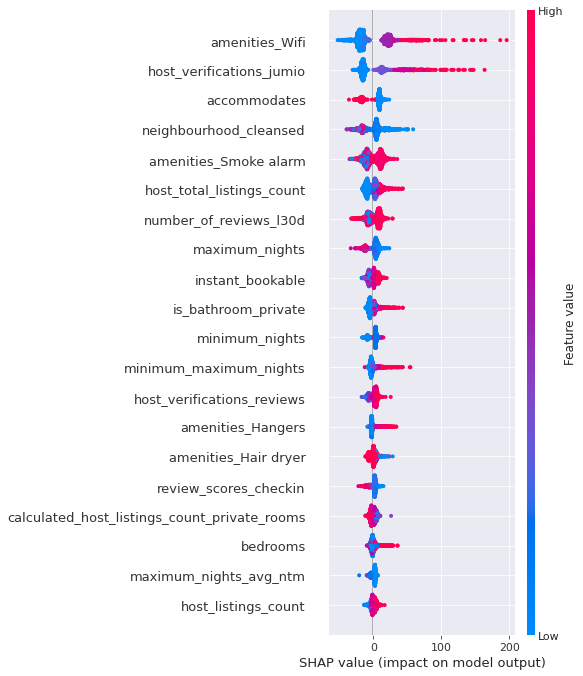

In [12]:
explainer = shap.TreeExplainer(model)

features_to_look_at = model.feature_importances_.argsort()
features_to_look_at = list(X_test.columns[features_to_look_at])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features_to_look_at)